# Nonogramm Löser 

Erstellt mithilfe von GPT4.

Der Code löst ein Nonogramm, ein Logikrätsel, bei dem es darum geht, eine Tabelle so mit "1" (für gefüllte Zellen) und "0" (für leere Zellen) zu füllen, dass die Vorgaben für jede Zeile und jede Spalte erfüllt werden. Diese Vorgaben bestehen aus Sequenzen von Zahlen, die angeben, wie viele aufeinanderfolgende Zellen in dieser Zeile oder Spalte gefüllt sein sollen, getrennt durch mindestens eine leere Zelle. Hier ist eine Schritt-für-Schritt-Erklärung des Codes:
1. constraints_to_possibilities(length, constraints)

Diese Funktion generiert alle möglichen Zeilen oder Spalten basierend auf den Vorgaben. Zum Beispiel, für eine Zeile der Länge 5 und die Vorgaben [3, 1], würden die Möglichkeiten [1, 1, 1, 0, 1] sein, da drei gefüllte Zellen gefolgt von einer leeren Zelle und einer weiteren gefüllten Zelle die Vorgaben erfüllen. Diese Funktion nutzt Rekursion, um alle Kombinationen zu erkunden.
2. check_compatibility(possibility, fixed)

Diese Funktion überprüft, ob eine mögliche Zeile oder Spalte mit den bereits festgelegten Zellen auf dem Spielfeld kompatibel ist. Eine Möglichkeit ist nur dann kompatibel, wenn alle festgelegten Zellen mit den Zellen in der Möglichkeit übereinstimmen.
3. update_fixed(fixed, possibilities)

Diese Funktion aktualisiert die festgelegten Zellen basierend auf den aktuellen Möglichkeiten. Wenn alle Möglichkeiten an einer bestimmten Position eine "1" haben, wird diese Position auf "1" festgelegt. Gleiches gilt für "0". Wenn es gemischte Möglichkeiten gibt, bleibt die Zelle unentschieden (-1).
4. Der Hauptalgorithmus

    Der Code initialisiert das Spielfeld mit -1, was bedeutet, dass alle Zellen zu Beginn unentschieden sind.
    Für jede Zeile und Spalte werden alle Möglichkeiten basierend auf den Vorgaben generiert.
    Der Code betritt eine Schleife, die so lange wiederholt wird, bis keine Änderungen mehr am Spielfeld vorgenommen werden können. In jedem Durchlauf:
        Für jede Zeile werden nur die mit dem aktuellen Zustand des Spielfelds kompatiblen Möglichkeiten behalten. Anschließend wird versucht, basierend auf diesen Möglichkeiten festgelegte Werte zu aktualisieren.
        Das Gleiche passiert für jede Spalte.

Ergebnis

Das Ergebnis ist ein vollständig gelöstes Nonogramm, bei dem alle Zellen entsprechend den Vorgaben mit "1" oder "0" gefüllt sind.

Diese Herangehensweise nutzt eine Kombination aus Brute-Force (um alle möglichen Zeilen und Spalten zu generieren) und Logik (um die Möglichkeiten basierend auf bereits festgelegten Zellen zu reduzieren), um das Rätsel zu lösen.

In [1]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation

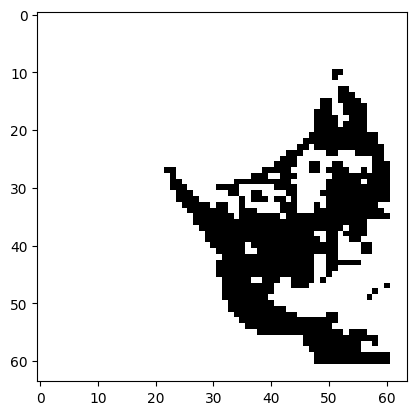

In [2]:
SIZE = 64
CONTRAST_VALUE = 190

img_colord = Image.open('ressources/Cat.jpeg')
img_colord.thumbnail((SIZE, SIZE))  # resizes image in-place
img_colord_plot = plt.imshow(img_colord)
img_gray = img_colord.convert('L')
img_plot = plt.imshow(img_gray, cmap='gray')

img = np.asarray(img_gray)
array = np.zeros((SIZE, SIZE), dtype=int)

for i, line in enumerate(img):
    for j, pixel in enumerate(line):
        if pixel > CONTRAST_VALUE:
            array[i][j] = 0
        else:
            array[i][j] = 1
imgplot = plt.imshow(array, cmap='binary')

row_restrictions = []
col_restrictions = []

for i in range(SIZE):
    row_restrictions.append([])
    col_restrictions.append([])
    for j in range(SIZE):
        if array[i][j] == 1:
            if len(row_restrictions[i]) == 0:
                row_restrictions[i].append(1)
            elif array[i][j-1] == 1:
                row_restrictions[i][len(row_restrictions[i]) - 1] += 1
            else:
                row_restrictions[i].append(1)

        if array[j][i] == 1:
            if len(col_restrictions[i]) == 0:
                col_restrictions[i].append(1)
            elif array[j-1][i] == 1:
                col_restrictions[i][len(col_restrictions[i]) - 1] += 1
            else:
                col_restrictions[i].append(1)

# print(f'row_restrictions = {row_restrictions}')
# print(f'col_restrictions = {col_restrictions}')

In [3]:
boards = []

def visualize_nonogram(board):
    fig, ax = plt.subplots()
    ax.imshow(board, cmap='binary', interpolation='nearest')
    for i in range(len(board)):
        for j in range(len(board[0])):
            ax.text(j, i, str(board[i, j]), ha='center', va='center', color='red' if board[i, j] == -1 else 'black')
    ax.set_xticks(np.arange(len(board[0]))-0.5)
    ax.set_yticks(np.arange(len(board))-0.5)
    ax.grid(color='black', linewidth=2)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

def solve_and_visualize_nonogram(row_restrictions, col_restrictions):
    def constraints_to_possibilities(length, constraints):
        """Generate all possible rows or columns based on constraints."""
        total_spaces = sum(constraints) + len(constraints) - 1
        free_spaces = length - total_spaces
        possibilities = []

        def generate_possibilities(prefix, constraints, free_spaces):
            if not constraints:
                possibilities.append(prefix + [0]*free_spaces)
                return
            first, *rest = constraints
            for space in range(free_spaces + 1):
                new_prefix = prefix + [0]*space + [1]*first + ([0] if rest else [])
                generate_possibilities(new_prefix, rest, free_spaces - space)

        generate_possibilities([], constraints, free_spaces)
        return possibilities

    def check_compatibility(possibility, fixed):
        """Check if a possibility is compatible with the already fixed positions."""
        return all(fixed[i] == -1 or fixed[i] == possibility[i] for i in range(len(fixed)))

    def update_fixed(fixed, possibilities):
        """Update fixed positions based on current possibilities."""
        for i in range(len(fixed)):
            if fixed[i] == -1:  # If position not fixed yet
                vals = [p[i] for p in possibilities]
                if all(vals):  # If all possibilities have a 1
                    fixed[i] = 1
                elif not any(vals):  # If all possibilities have a 0
                    fixed[i] = 0

    rows = len(row_restrictions)
    cols = len(col_restrictions)
    board = np.full((rows, cols), -1)

    row_possibilities = [constraints_to_possibilities(cols, row) for row in row_restrictions]
    col_possibilities = [constraints_to_possibilities(rows, col) for col in col_restrictions]

    changes = True
    while changes:
        changes = False
        for i, row in enumerate(row_possibilities):
            row_possibilities[i] = [p for p in row if check_compatibility(p, board[i])]
            old_row = board[i].copy()
            update_fixed(board[i], row_possibilities[i])
            if not np.array_equal(board[i], old_row):
                changes = True
                boards.append(np.copy(board))  # Visualize after each row update

        for j, col in enumerate(col_possibilities):
            col_possibilities[j] = [p for p in col if check_compatibility(p, board[:, j])]
            old_col = board[:, j].copy()
            update_fixed(board[:, j], col_possibilities[j])
            if not np.array_equal(board[:, j], old_col):
                changes = True
                boards.append(np.copy(board))  # Visualize after each column update

    return board.astype(int)

solve_and_visualize_nonogram(row_restrictions, col_restrictions)
print(len(boards))

428


In [4]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 75
plt.rcParams['animation.embed_limit'] = 300
plt.ioff()
fig, ax = plt.subplots()


def animate(t):
    plt.cla()
    plt.imshow(boards[t], cmap='binary')
animation.FuncAnimation(fig, animate, frames=len(boards))